# YOUR PROJECT TITLE

> **Note the following:** 
> 1. This is *not* meant to be an example of an actual **data analysis project**, just an example of how to structure such a project.
> 1. Remember the general advice on structuring and commenting your code from [lecture 5](https://numeconcopenhagen.netlify.com/lectures/Workflow_and_debugging).
> 1. Remember this [guide](https://www.markdownguide.org/basic-syntax/) on markdown and (a bit of) latex.
> 1. Turn on automatic numbering by clicking on the small icon on top of the table of contents in the left sidebar.
> 1. The `dataproject.py` file includes a function which will be used multiple times in this notebook.

Data analysis with data from the Federal Reserve Bank of st. Louis.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from matplotlib_venn import venn2 # install with pip install matplotlib-venn
import pandas_datareader # install with `pip install pandas-datareader`
import pydst # install with `pip install git+https://github.com/elben10/pydst`
import datetime
import math

# autoreload modules when code is run
%load_ext autoreload
%autoreload 2

# local modules
import dataproject

# Read and clean data

importing tables from the FRED source, we have chosen 1-Year Treasury Constant Maturity Rate (DGS1), 10-Year Treasury Constant Maturity Rate (DGS10) and Wilshire 5000 Full Cap Price Index (Will5000prfc) where all the timeseries end in 25th of March 2020. Note the different starttime, this will be corrected for in the code later.

In [3]:
#Setting times:
start = datetime.datetime(1950,1,1)
end = datetime.datetime(2020,3,27)

#Loading data for stock index, two interest rates for rate spread:
stocks = pandas_datareader.data.DataReader('WILL5000PRFC','fred',start,end)
dgs1 = pandas_datareader.data.DataReader('dgs1','fred',start,end)
dgs10 = pandas_datareader.data.DataReader('dgs10','fred',start,end)

#Renaming stocks-column for easier retreival:
stocks.rename(columns={'WILL5000PRFC':'stocks'},inplace=True)

#Merging data into single dataframe:
mellemregning = pd.merge(stocks,dgs1,how='inner',left_index=True,right_index=True)
data = pd.merge(mellemregning,dgs10,how='inner',left_index=True,right_index=True)

#Deleting NaN:
data.dropna(inplace=True)

#Defining spread between the 1-year and 10-year maturity rate
data['spread'] = data['dgs10']-data['dgs1']
data['logstocks'] = [
    math.log(i)
    for i in data['stocks']
]
#printing data table
data


,stocks,dgs1,dgs10,spread,logstocks
DATE,,,,,
1970-12-31,830.27,4.94,6.50,1.56,6.721751
1971-01-29,873.31,4.23,6.09,1.86,6.772291
1971-02-26,885.37,3.69,6.14,2.45,6.786006
1971-03-31,923.13,3.92,5.53,1.61,6.827770
1971-04-30,955.25,4.77,6.08,1.31,6.861973
...,...,...,...,...,...
2020-03-20,23082.46,0.15,0.92,0.77,10.046828
2020-03-23,22463.62,0.17,0.76,0.59,10.019652
2020-03-24,24542.52,0.25,0.84,0.59,10.108162


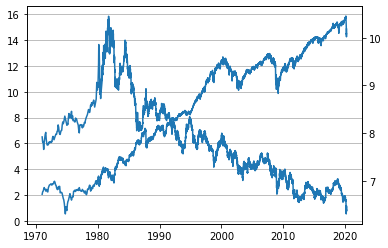

In [4]:
#Plotting:
fig, ax1 = plt.subplots()

#defining axes
ax1.plot(data['dgs10'])
ax1.grid(axis='y')

#adding an second y-axis
ax2 = ax1.twinx()
ax2.plot(data['logstocks'])


In [ ]:
#importing econometrics package for OLS
import statsmodels.api as sm

In the following code we perform a regression with OLS. 
Our model is $log(stocks)=constant+dgs10$. 
Note that we have chosen the 10-year maturity rate, since this will represent the most realistic trading trade-off.

In [5]:
#defining regression model: logstocks=constant+dgs10
X = sm.add_constant(data['dgs10'])
model = sm.OLS(data['logstocks'],X)
results = model.fit()
results.params
print(results.summary())
print(np.std(data['logstocks']))

OLS Regression Results                            
Dep. Variable:              logstocks   R-squared:                       0.846
Model:                            OLS   Adj. R-squared:                  0.846
Method:                 Least Squares   F-statistic:                 5.610e+04
Date:                Sun, 29 Mar 2020   Prob (F-statistic):               0.00
Time:                        13:10:29   Log-Likelihood:                -4470.2
No. Observations:               10176   AIC:                             8944.
Df Residuals:                   10174   BIC:                             8959.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         10.4443      0.008   1350.179      0.000      10.429      10.460
d

We conclude that the dgs10 parameter affects the 10-year maturity rate significantly negative, thus when the maturity rate increases with $1 \%$-point